
The CNN model is translational invariant, as it applies filters to local image regions. That means that similar features, no mater where they occur in the image are treated as same. This is not the case with fully connected neural network. 


In [211]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import autograd
import torch.nn.functional as F

#Prepare the data.
import torch
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
from numpy import linalg as LA

dtype = torch.FloatTensor

images = np.load("./data/images.npy")
labels = np.load("./data/labels.npy")

images = np.reshape(images, (images.shape[0], images.shape[1] * images.shape[2]))

images = images - images.mean()
images = images/images.std() 

train_seqs = images[0:40000]
val_seqs = images[40000:50000]

train_labels = labels[0:40000]
cv_labels = labels[40000:50000]

In [212]:
HEIGHT, WIDTH, NUM_CLASSES, NUM_OPT_STEPS = 26, 26, 5, 5000
learning_rate = 0.01

class TooSimpleConvNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # 3x3 convolution that takes in an image with one channel
        # and outputs an image with 8 channels.
        self.conv1 = torch.nn.Conv2d(1, 8, kernel_size=3)
        # 3x3 convolution that takes in an image with 8 channels
        # and outputs an image with 16 channels. The output image
        # has approximately half the height and half the width
        # because of the stride of 2.
        self.conv2 = torch.nn.Conv2d(8, 16, kernel_size=3, stride=2)
        # 1x1 convolution that takes in an image with 16 channels and
        # produces an image with 5 channels. Here, the 5 channels
        # will correspond to class scores.
        self.final_conv = torch.nn.Conv2d(16, 5, kernel_size=1)
    
    def forward(self, x):
        # Convolutions work with images of shape
        # [batch_size, num_channels, height, width]
        x = x.view(-1, HEIGHT, WIDTH).unsqueeze(1)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        n, c, h, w = x.size()
        x = F.avg_pool2d(x, kernel_size=[h, w])
        x = self.final_conv(x).view(-1, NUM_CLASSES)
        return x
        

In [213]:
model = TooSimpleConvNN()

In [214]:
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate)

In [215]:
def train(batch_size):
    model.train()
    
    i = np.random.choice(train_seqs.shape[0], size = batch_size, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = Variable(torch.from_numpy(train_labels[i].astype(np.int)))
    
    optimizer.zero_grad()
    y_hat = model(x)
    loss = F.cross_entropy(y_hat, y)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

In [216]:
def accuracy(y, y_hat):
    count = 0
    for i in range(y.shape[0]):
        if y[i] == y_hat[i]:
            count += 1
    return count/y.shape[0]

In [217]:
import random

#approx train accuracy() that extracts 1,000 random training
#instances, creates a single batch with all of these inputs, computes integer predictions
#for each example in the batch, and returns an accuracy by comparing these
#predictions to the ground-truth labels. 

def approx_train_accuracy():
    i = np.random.choice(train_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(train_seqs[i].astype(np.float32)))
    y = train_labels[i].astype(np.int)
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)
    return acc

#val accuracy() that creates a single batch with all validation
#examples, computes integer predictions for each example in the batch, and returns
#an accuracy by comparing these predictions to the ground-truth labels.

def val_accuracy():
    i = np.random.choice(val_seqs.shape[0], size = 1000, replace=False)
    x = Variable(torch.from_numpy(val_seqs[i].astype(np.float32)))
    y = cv_labels[i].astype(np.int) 
    
    output = model(x)
    y_hat = np.argmax(output.data.numpy(), axis =1)
    acc = accuracy(y,y_hat)

    return acc

In [218]:
for m in model.children():
    m.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)
train_accs, val_accs = [], []
batch_size = 10
for i in range(2000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.20  0.20
   100  0.24  0.24
   200  0.53  0.51
   300  0.54  0.51
   400  0.52  0.50
   500  0.58  0.56
   600  0.56  0.56
   700  0.60  0.58
   800  0.62  0.64
   900  0.56  0.55
  1000  0.63  0.62
  1100  0.59  0.58
  1200  0.53  0.54
  1300  0.63  0.63
  1400  0.64  0.65
  1500  0.63  0.62
  1600  0.65  0.63
  1700  0.63  0.64
  1800  0.63  0.59
  1900  0.65  0.64


max_train accuracy:  0.653
max_val accuracy:  0.653


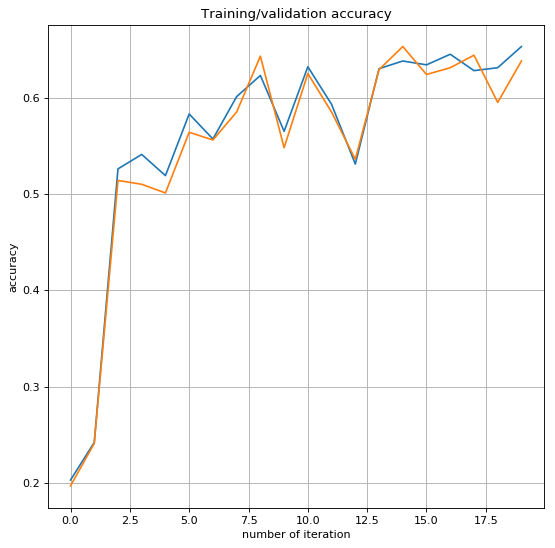

In [219]:
import matplotlib.pyplot as plt


t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

In [220]:
for m in model.children():
    m.reset_parameters()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.05)
train_accs, val_accs = [], []
batch_size = 300
for i in range(5000):
    l = train(batch_size)
    if i % 100 == 0:
        train_accs.append(approx_train_accuracy())
        val_accs.append(val_accuracy())
        print("%6d %5.2f %5.2f" % (i, train_accs[-1], val_accs[-1]))

     0  0.17  0.19
   100  0.70  0.72
   200  0.72  0.75
   300  0.78  0.78
   400  0.81  0.81
   500  0.77  0.80
   600  0.70  0.73
   700  0.79  0.78
   800  0.80  0.81
   900  0.79  0.80
  1000  0.84  0.80
  1100  0.80  0.83
  1200  0.81  0.82
  1300  0.82  0.84
  1400  0.77  0.77
  1500  0.83  0.83
  1600  0.84  0.84
  1700  0.84  0.84
  1800  0.84  0.82
  1900  0.83  0.84
  2000  0.82  0.83
  2100  0.82  0.82
  2200  0.81  0.81
  2300  0.83  0.82
  2400  0.79  0.79
  2500  0.84  0.81
  2600  0.84  0.84
  2700  0.83  0.84
  2800  0.83  0.82
  2900  0.86  0.85
  3000  0.85  0.85
  3100  0.83  0.86
  3200  0.84  0.84
  3300  0.84  0.85
  3400  0.84  0.86
  3500  0.84  0.85
  3600  0.86  0.86
  3700  0.83  0.84
  3800  0.83  0.85
  3900  0.88  0.85
  4000  0.84  0.84
  4100  0.84  0.84
  4200  0.85  0.84
  4300  0.82  0.82
  4400  0.86  0.85
  4500  0.83  0.83
  4600  0.85  0.86
  4700  0.87  0.84
  4800  0.82  0.84
  4900  0.86  0.84


max_train accuracy:  0.879
max_val accuracy:  0.859


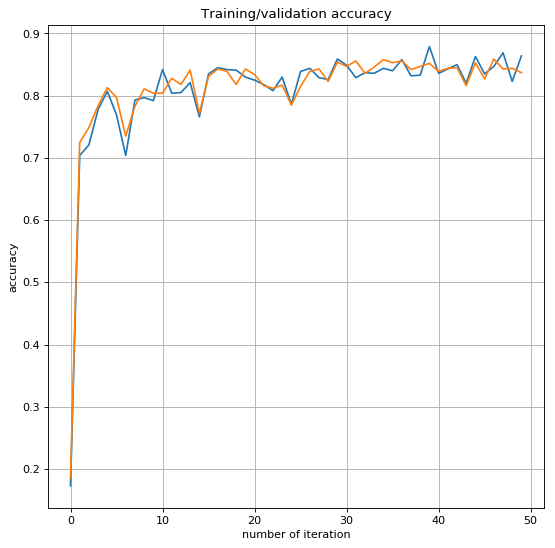

In [221]:
t = np.arange(0,len(train_accs),1)

s = train_accs
k = val_accs
print("max_train accuracy: ", max(train_accs))
print("max_val accuracy: ", max(val_accs))
plt.figure(figsize=(8,8), dpi = 80)
plt.plot(t, s, t, k)

plt.xlabel('number of iteration')
plt.ylabel('accuracy')
plt.title('Training/validation accuracy')
plt.grid(True)
plt.show()

# Optimizations:

For an initial parameter setting of (learning rate = 0.001, Batch size = 10, Opt Steps = 2000) Validation accuracy is 65%

After optimization, best validation accuracy of 85% is achieved at (earning rate = 0.05, Batch size = 300, Opt Steps = 5000)